# Classificação de planetas

## Autor

Lucas Gabriel Bezerra - 180125770

GitHub: [lucasgbezerra](https://github.com/lucasgbezerra/)

## Objetivo

O objetivo deste artigo é criar e treinar um modelo capaz de classificar os planetas e plutão conhecidos no sistema solar.

## Motivação

A exploração espacial nos últimos anos tem crescido consideravelmente. Empresas privadas passaram a dedicar seus esforços a algo que era totalmente governamental.

Pensando nisso, um sistema de classificação de planetas pode ser muito útil para sondas e satelites enviadas ao espaço.

## Modelagem

## Passo 1 - Instalando depêndencias

- Instalação da biblioteca DuckDuckGo, com o gerenciador de pacotes pip, para realizar a busca pelas imagens utilizadas para o treinamento do modelo e realização de testes.

- Instalação da biblioteca de deep learning fastai.

In [2]:
!pip install -Uqq duckduckgo_search fastai

## Passo 2 - Baixando imagens

Criação de uma função para buscar imagens(limitado a 50) a partir do termo passado como paramêtro utilizando a biblioteca do motor de pesquisa DuckDuckGo.

In [3]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastai.vision.all import *

def search_images(term, max_images=100):
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Buscando duas (banana, maça) imagens para verificar o funcionamento da função e para testes futuros.

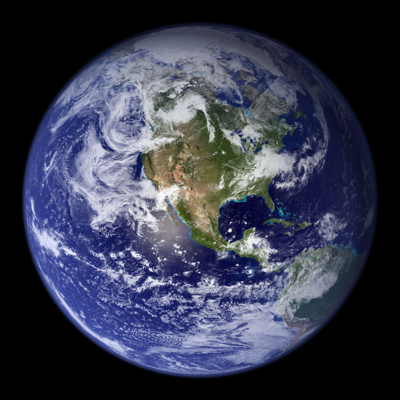

In [4]:
from fastai.vision.all import *
from fastdownload import download_url

urls = search_images('earth', max_images=1)
dest = 'earth.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(400,400)

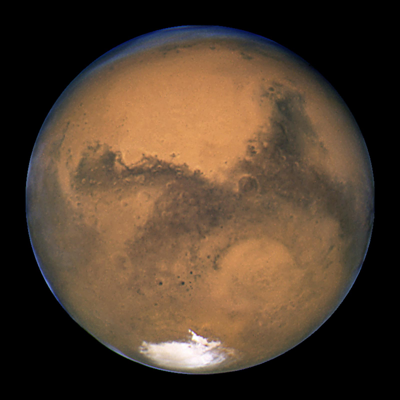

In [5]:
urls = search_images('mars', max_images=1)
dest = 'mars.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(400,400)

Lista de 40 frutas populares que serão utilizadas para pesquisa e como label dos conjuntos de imagens.

In [6]:
planets = [
'Mercury',
'Venus',
'Earth',
'Mars',
'Jupiter',
'Saturn',
'Uranus',
'Neptune',
'Pluto'
]

Utilizando a função criada para buscar imagens, vamos buscar um conjunto de imagens das diferentes frutas. 

As imagens serão reduzidas e salvas em diretórios, onde cada pasta contem imagens de uma raça, para uso posterior.

In [9]:
searches = planets
path = Path('planets')

from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'Planet {o}'))
    sleep(1)
    resize_images(path/o, max_size=400, dest=path/o)


Antes de realizar o treinamento do modelo é indicado realizar uma verificação das imagens baixadas, a fim de buscar imagens que possam ter sido baixadas incorretamente e dessa forma possam causar falha no modelo treinado. As imagens baixadas incorretamente serão excluidas.

In [6]:
failed_imgs = verify_images(get_image_files(path))
failed_imgs.map(Path.unlink)
print(f"Número de imagens incorretas: {len(failed_imgs)}")

Número de imagens incorretas: 15


### Passo 2 - Formantando conjunto de Imagens

Antes de realizar o treinamento do modelo um bloco de dados será gerado.

O **Datablock** é composto por diversos parâmetros, os parâmetros utilizados nessa modelagem foram:
- *blocks=(ImageBlock, CategoryBlock)*: o tipo de entrada(imagens de cachorro) e saídas (categorias ou raças de cachorros)
- *get_items=get_image_files*: retorna as lista de imagens armazenadas no path
- *splitter=RandomSplitter(valid_pct=0.2, seed=42)*: Divisão do dado entre conjunto de validação e de treinamento, sendo 20% dos dados para validação
- *get_y=parent_label*: o valor y é o nome do 'pai' de cada arquivo, que no caso em questão é a pasta com o a raça dele.
- *item_tfms=[Resize(192, method='squish')]*: reduz o tamanho da imagem antes do treinamento para 192x192 pixels.

In [21]:
db_planets = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
)

### Data augmentation
A fim de melhorar o desempenho do treinamento, e visto a baixa quantidade de dados disponíveis (30 para cada fruta), uma estratégia de transformação das imagens será usada. 

O Data augmentation é a criação de variações aleatórias dos dados de entrada, de tal forma que elas pareção diferentes, apesar de serem a mesma image.

Algumas informações sobre métodos e funções usadas: 
- *aug_transforms* é um padrão de augmentations indicado na aula e com boa performance para imagens de fotos naturais.
- *batch_tfms* é um método do fastai que indica o uso dessas transformações.
- *RandomResizedCrop*: Recorta e redimenciona de maneira aleátoria a imagem

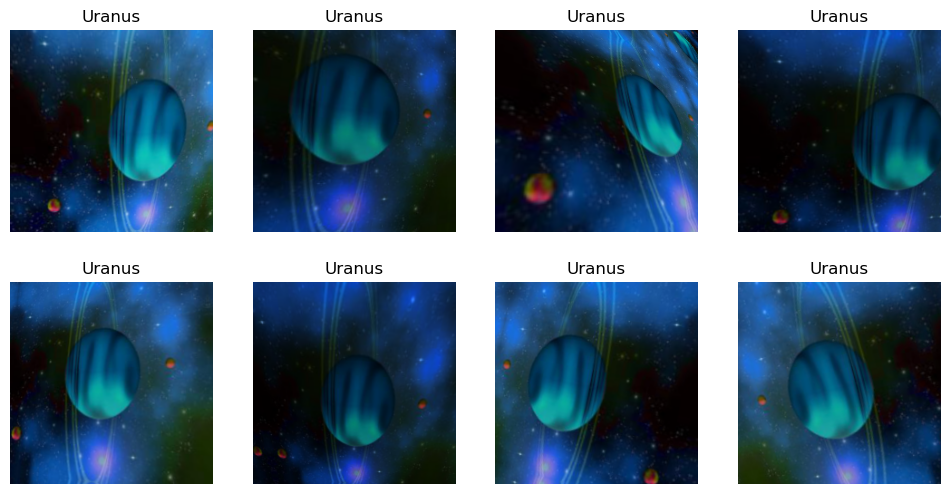

In [11]:
db_planets = db_planets.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5), 
    batch_tfms=aug_transforms(mult=2))
dls = db_planets.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Passo 3 - Treinando o modelo e usando isso para limpar os dados

Criando o *learner* e o fine-tune.

Para treinar o modelo foi utilizado o modelo de visão(*vision model*) **resnet18**.

Além disso o fastai possui o **fine_tune()** que é um método para 'tunar' um modelo, onde ele parte de pesos de uma rede treinada para treinar o modelo desejado.

In [12]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

/home/lucas/miniconda3/envs/fastai_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/lucas/miniconda3/envs/fastai_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Matriz de confusão
A matriz de confusão é uma maneira de ver quais erros estão sendo cometidos pelo modelo, quais as frutas que ele mais confunde.

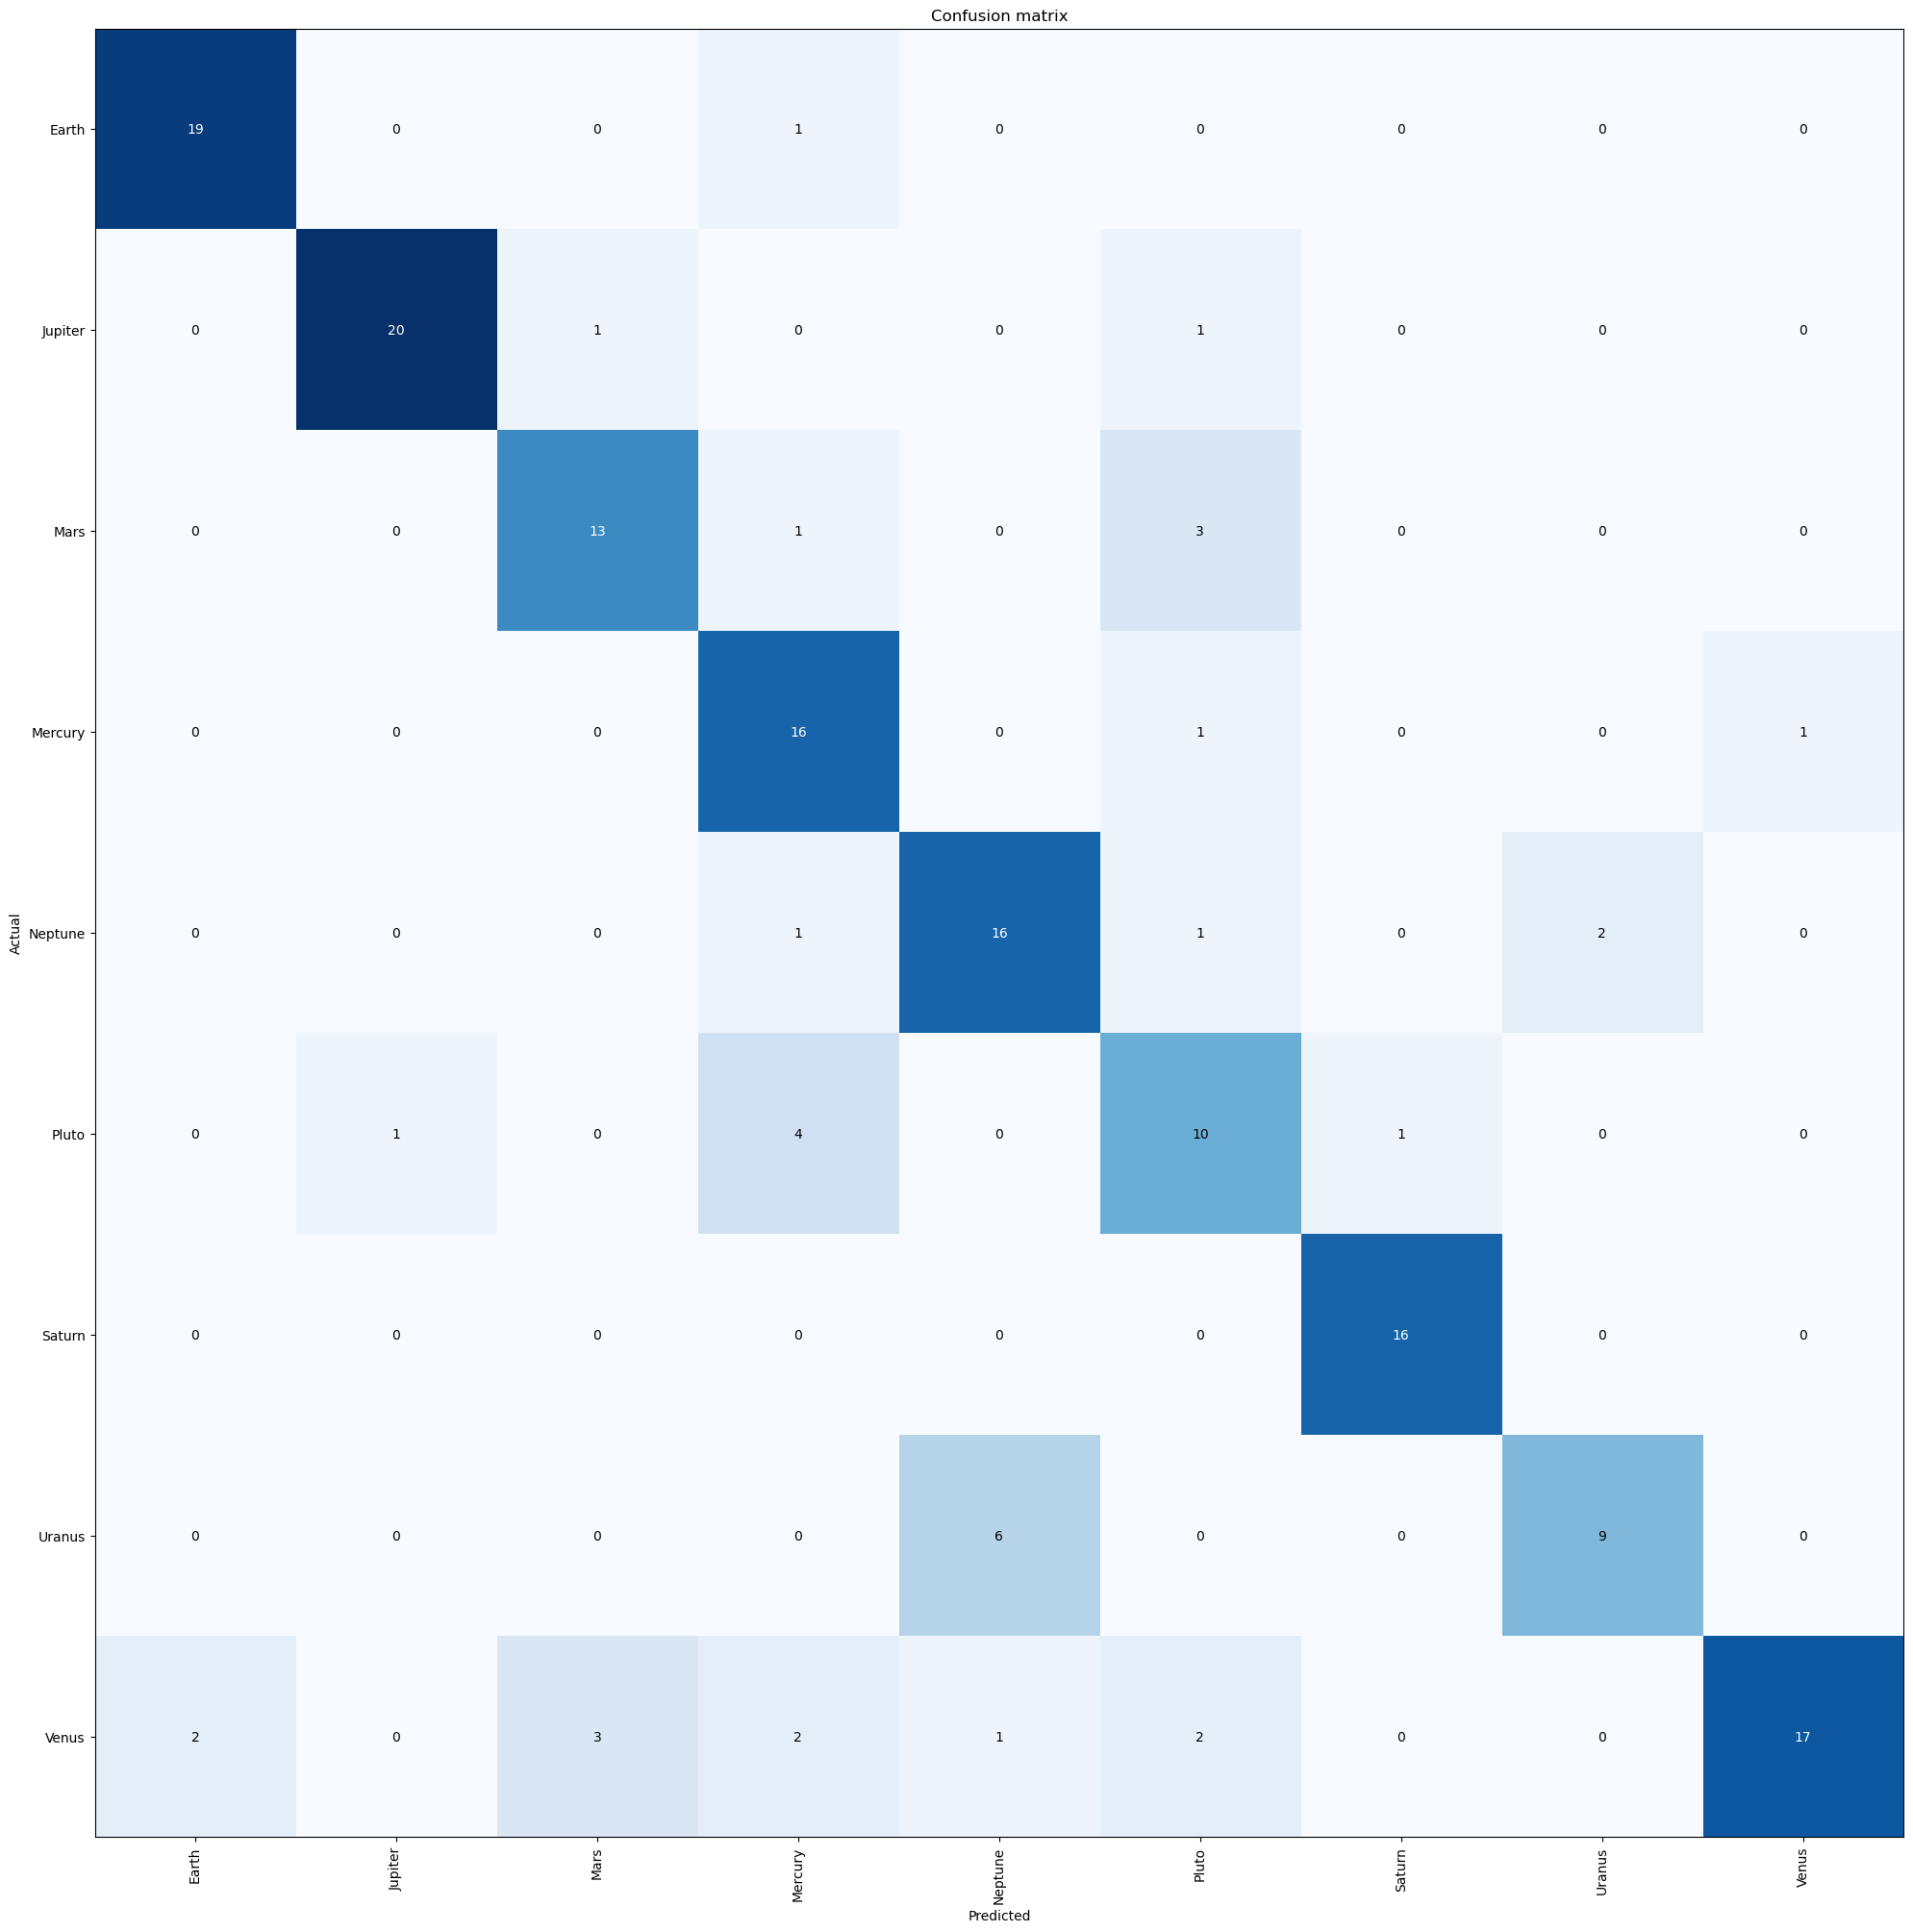

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

As colunas da matriz representam as imagens de frutas que o modelo prediz, e as linhas representam o conjunto de imagens de frutas utilizadas no treinamento.

A diagonal principal representa os acertos (predição condiz com a label). Enquanto as outras intercessões mostram os erros cometidos, sendo quanto maior o número de uma celula mais vezes ocorreu a confusão.

Para entender melhor o que os erros mostram (um erro do modelo ou das imagens) pode ser útil ordenar as imagens pela perda (loss).

**Quanto mais incorreto é o modelo maior a perda (loss)**, especialmente quando o erro ocorre com alta confiança. A perda (loss) também é alta quando a predição está correta porém com pouca confiança na resposta.

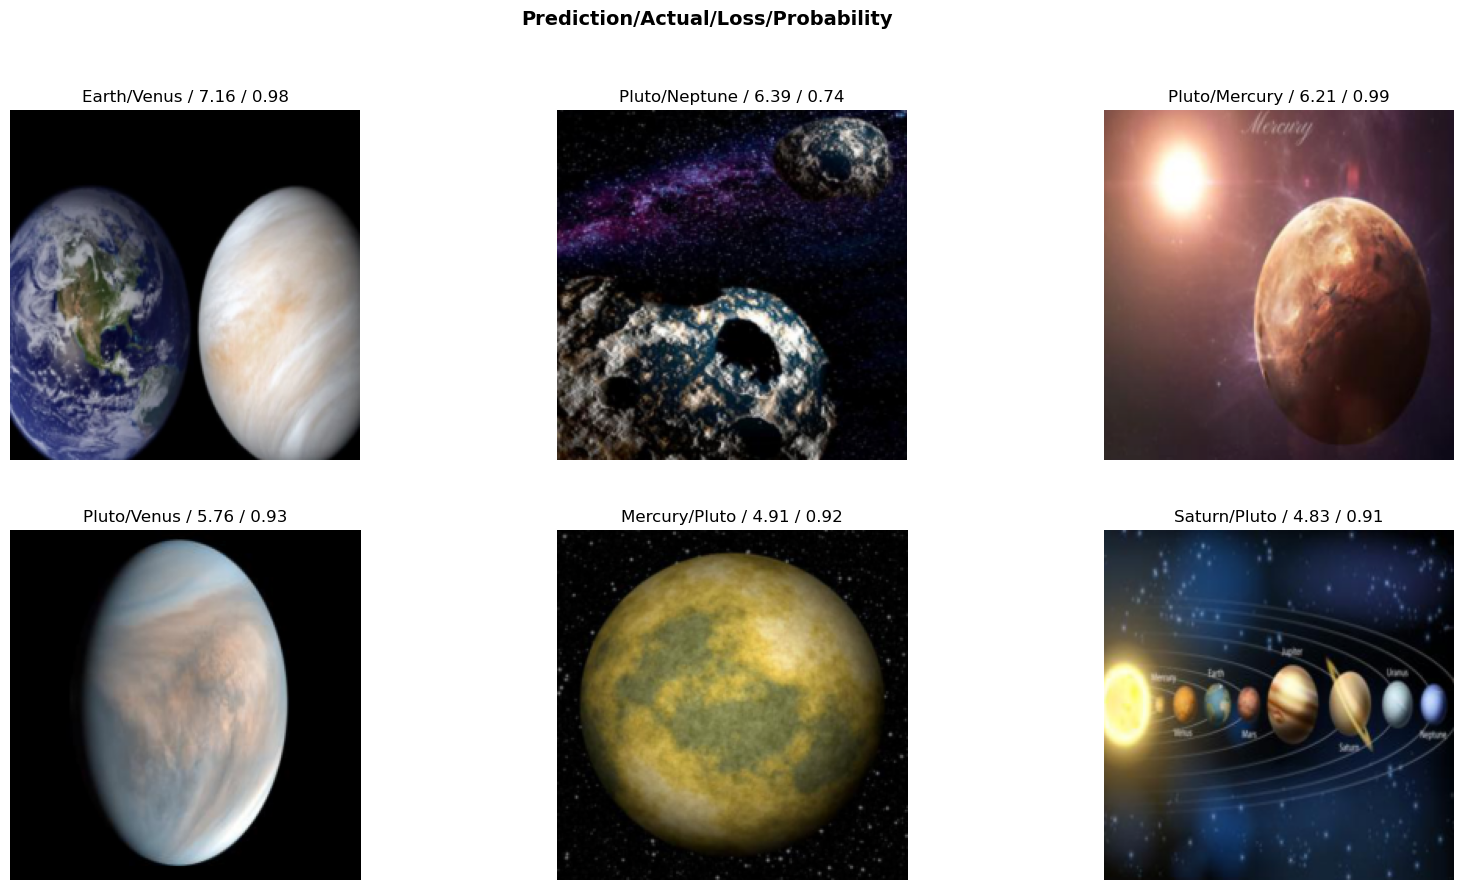

In [14]:
interp.plot_top_losses(6, figsize=(20,10))

Algumas das imagens foram confusões justas devido a semelhança, como é o caso da Blueberry e Grape. Em outros casos a confusão se dá pela imagem baixada ser de outro produto que não o desejado, por exemplo a grapefruit ( que está taxada como grape(uva)

Após esse processo o modelo auxiliou a identificar onde o dado pode ser mais problemático de maneira rápida.

Para melhorar o conjunto de dados é preciso fazer uma **limpeza dos dados**. O fastai possui uma GUI para isso chamada *ImageClassifierCleaner*, essa GUI será usada para selecionar imagens para remoção ou realocar.

In [15]:
from fastai.vision.widgets import *

cleaner = ImageClassifierCleaner(learn)
cleaner

Para realizar as remoções e realocamento das imagens indicadas basta utilizar esses 2 loops:

In [16]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Uma vez que ocorre a limpeza dos dados, o modelo pode ser **re-treinado** e alcançar melhores resultados.

In [22]:
dls = db_planets.dataloaders(path)
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

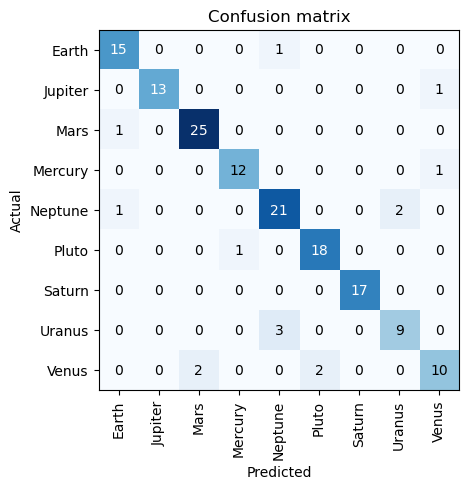

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Passo 3 - Buscando o melhor modelo

Depois de ter os dados limpos e treinar novamente o modelo, o resultado obtido pelo resnet18 foi de 9% de taxa de erro, 39% de perda de validação e 22% de perda de treinamento, demorando cerca de 30 segundos em cada época.

Com isso em mente resolvi buscar novos modelos, que possam trazer resultados melhores. 
Para ter uma base do que seria um bom modelo, resolvi buscar estatisticas já existentes de modelos conhecidos. O GitHub do [Pytorch Image Models (timm)](https://github.com/rwightman/pytorch-image-models#introduction) foi a referência utilizada

In [5]:
import pandas as pd

url = 'https://raw.githubusercontent.com/rwightman/pytorch-image-models/main/results/results-imagenet.csv'
df_results = pd.read_csv(url)

In [6]:
df_results.head()

model    top1  top1_err    top5  top5_err  \
0            beit_large_patch16_512  88.602    11.398  98.656     1.344   
1            beit_large_patch16_384  88.406    11.594  98.606     1.394   
2             tf_efficientnet_l2_ns  88.350    11.650  98.650     1.350   
3         tf_efficientnet_l2_ns_475  88.232    11.768  98.546     1.454   
4  deit3_large_patch16_384_in21ft1k  87.716    12.284  98.512     1.488   

   param_count  img_size  crop_pct interpolation  
0       305.67       512     1.000       bicubic  
1       305.00       384     1.000       bicubic  
2       480.31       800     0.960       bicubic  
3       480.31       475     0.936       bicubic  
4       304.76       384     1.000       bicubic

A fim de agrupar as arquiteturas a partir de suas similaridades, será adicionada a tabela a coluna family

In [7]:
url_infer = 'https://raw.githubusercontent.com/rwightman/pytorch-image-models/main/results/benchmark-infer-amp-nhwc-pt111-cu113-rtx3090.csv'

def get_data(col):
    df = pd.read_csv(url_infer).merge(df_results, on='model')
    df['secs'] = 1. / df[col]
    df['family'] = df.model.str.extract('^([a-z]+?(?:v2)?)(?:\d|_|$)')
    df = df[~df.model.str.endswith('gn')]
    df.loc[df.model.str.contains('in22'),'family'] = df.loc[df.model.str.contains('in22'),'family'] + '_in22'
    df.loc[df.model.str.contains('resnet.*d'),'family'] = df.loc[df.model.str.contains('resnet.*d'),'family'] + 'd'
    return df[df.family.str.contains('^re[sg]netd?|beit|convnext|levit|efficient|vit|vgg|swin')]

df = get_data('infer_samples_per_sec')


In [11]:
df.head()

model  infer_samples_per_sec  infer_step_time  infer_batch_size  \
12   levit_128s               21485.80           47.648              1024   
13  regnetx_002               17821.98           57.446              1024   
15  regnety_002               16673.08           61.405              1024   
17    levit_128               14657.83           69.849              1024   
18  regnetx_004               14440.03           70.903              1024   

    infer_img_size  param_count_x    top1  top1_err    top5  top5_err  \
12             224           7.78  76.514    23.486  92.870     7.130   
13             224           2.68  68.754    31.246  88.556    11.444   
15             224           3.16  70.256    29.744  89.534    10.466   
17             224           9.21  78.482    21.518  94.012     5.988   
18             224           5.16  72.396    27.604  90.838     9.162   

    param_count_y  img_size  crop_pct interpolation      secs   family  
12           7.78       224     0.900       bicubic  0.000047    levit  
13           2.68       224     0.875       bicubic  0.000056  regnetx  
15           3.16       224     0.875       bicubic  0.000060  regnety  
17           9.21       224     0.900       bicubic  0.000068    levit  
18           5.16       224     0.875       bicubic  0.000069  regnetx

In [12]:
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 33.0 MB/s eta 0:00:00m eta 0:00:010:00:01
  Using cached tenacity-8.1.0-py3-none-any.whl (23 kB)


In [13]:
import plotly.express as px

px.scatter(df, width=1000, height=800, size=df['infer_img_size']**2, title='Inferencia',x='secs',  y='top1', log_x=True, color='family', hover_name='model', hover_data=['infer_img_size'])

## Escolhendo 3 modelos

## Passo 4 - Testando o modelo

Para utilizar o modelo basta usar a linha de código a seguir com uma imagem do cachorro. Será retornada a raça do cachorro e a probabilidade de correspondência obtida.

```python

data_type,_, probs = learn.predict(PILImage.create('imagem.jpg'))
```

In [24]:
fruit_type ,_, probs = learn.predict(PILImage.create('earth.jpg'))

print(f'Probabilidade de ser um {fruit_type} é de {probs.sort()[0][-1]*100:.2f}%')

Probabilidade de ser um Earth é de 99.99%


In [27]:
fruit_type ,_, probs = learn.predict(PILImage.create('mars.jpg'))

print(f'Probabilidade de ser um {fruit_type} é de {probs.sort()[0][-1]*100:.2f}%')

Probabilidade de ser um Mars é de 92.76%


## Deploy do modelo

### Exportar o modelo

O primeiro passo para realizar o deploy do modelo é necessário exportá-lo, para isso será usado o método export() do learner

In [25]:
learn.path = Path('.')
learn.export()

### Deploy no huggin Face

Seguindo os passos descritos no hugging face. Um space foi criado, clonado e o arquivo app.py foi criado.

O arquivo **app.py** foi preenchido com o script:

```python
import gradio as gr
from fastai.vision.all import *

learn = load_learner('export.pkl')
labels = learn.dls.vocab

def classify_image(img):
    pred,idx,probs = learn.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}

title = "Fruit Classifier"
examples = ['banana.jpg', 'jabuticaba.jpeg', 'laranja.jpg',  'maca.jpg', 'melancia.jpeg']

iface = gr.Interface(
    fn=classify_image,
    inputs=gr.inputs.Image(shape=(512, 512)),
    outputs=gr.outputs.Label(num_top_classes=3),
    title=title,
    examples=examples,
    )
iface.launch(inline=False)
```

O repositório com o **deploy** pode ser acessado no [huggingFace](https://huggingface.co/spaces/lucasgbezerra/fruit_classifier)

## Conclusão

Classificar uma grande quantidade de dados é custoso e mais difícil, usar o RandomResizedCrop, permitiu diminuir o número de dados de entrada para treinar o modelo e isso foi muito útil para diminuir o tempo de download de imagens.

Outro ponto importante da execução desse artigo foi a utilização do treinamento para facilitar a identificação de confusões com a matriz de confução e o melhoramento da base de dados com o *ImageClassifierCleaner()*, Isso ficou nítido após o retreino, com a mesma base de dados porém otimizada a precisão se mostrou maior.